# Integration Example

We can use [pynucastro](https://github.com/pynucastro/pynucastro) to generate the righthand side function for an astrophysical reaction network.

We'll create a CNO network that has the rates for all 4 CNO cycles + hot-CNO, as listed here:
[https://reaclib.jinaweb.org/popularRates.php](https://reaclib.jinaweb.org/popularRates.php)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pynucastro as pyna

In [4]:
rate_names = ["c12(p,g)n13",
              "c13(p,g)n14",
              "n13(,)c13",
              "n13(p,g)o14",
              "n14(p,g)o15",
              "n15(p,a)c12",
              "o14(,)n14",
              "o15(,)n15",
              "n15(p,g)o16",
              "o16(p,g)f17",
              "f17(,)o17",
              "o17(p,a)n14",
              "o17(p,g)f18",
              "f18(,)o18",
              "o18(p,a)n15",
              "o18(p,g)f19",
              "f19(p,a)o16",
              "o14(a,p)f17",
              "f17(p,g)ne18",
              "ne18(,)f18",
              "f18(p,a)o15"]
rl = pyna.ReacLibLibrary()
rates = rl.get_rate_by_name(rate_names)
rc = pyna.RateCollection(rates=rates)

We can visualize the network and rates linking the nuclei

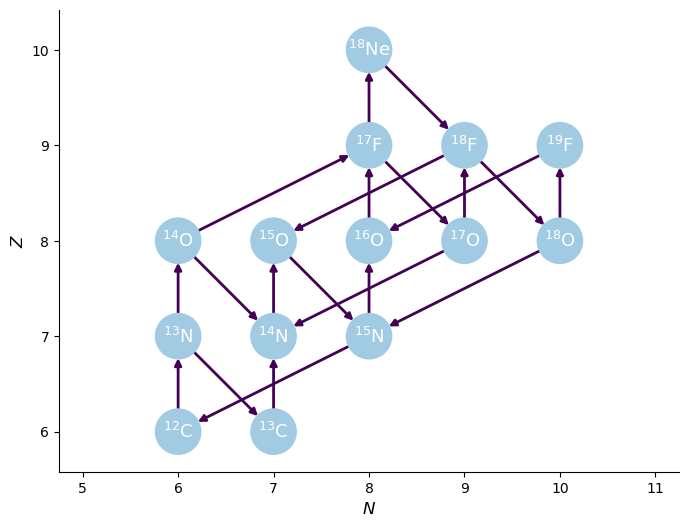

In [6]:
fig = rc.plot()

pynucastro can write out the python code needed to evaluate the reaction rates

In [8]:
pynet = pyna.PythonNetwork(rates=rates)
pynet.write_network("cno_integration_example.py")

In [9]:
#%cat cno_integration_example.py

Now we can import the network that was just created

In [10]:
import cno_integration_example as cno

We'll use the BDF solver from SciPy

In [11]:
from scipy.integrate import solve_ivp

Now we'll set the thermodynamic conditions.  We initialize mass fractions and then convert to molar fractions, since that's what the RHS uses

In [13]:
rho = 150
T = 1.5e7

X0 = np.zeros(cno.nnuc)
X0[cno.jp] = 0.7
X0[cno.jhe4] = 0.28
X0[cno.jc12] = 0.02

Y0 = X0/cno.A

In [14]:
Y0

array([0.7       , 0.07      , 0.00166667, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

In [15]:
tmax = 1.e20

sol = solve_ivp(cno.rhs, [0, tmax], Y0, method="BDF",
                dense_output=True, args=(rho, T), rtol=1.e-6, atol=1.e-6)

In [16]:
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.000e-04 ...  7.679e+19  1.000e+20]
        y: [[ 7.000e-01  7.000e-01 ...  5.177e-09  2.786e-10]
            [ 7.000e-02  7.000e-02 ...  2.441e-01  2.441e-01]
            ...
            [ 0.000e+00  3.467e-153 ...  1.275e-09  1.275e-09]
            [ 0.000e+00  1.098e-119 ... -1.564e-55 -4.073e-60]]
      sol: <scipy.integrate._ivp.common.OdeSolution object at 0x7f6b02ae8a50>
 t_events: None
 y_events: None
     nfev: 345
     njev: 20
      nlu: 63

Now we can plot the mass fractions.

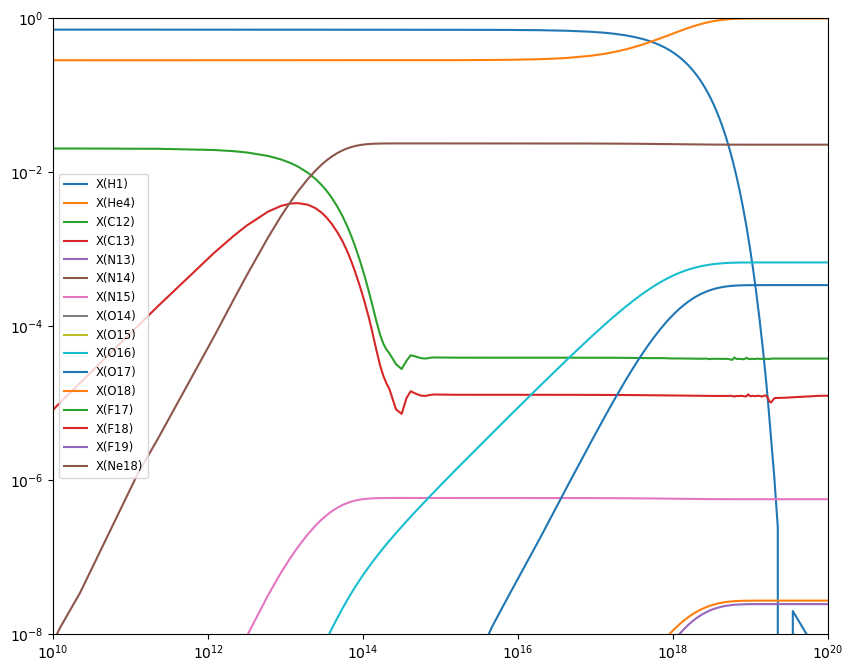

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

for n in range(cno.nnuc):
    ax.loglog(sol.t, sol.y[n,:] * cno.A[n], label=f"X({cno.names[n].capitalize()})")

ax.set_xlim(1.e10, 1.e20)
ax.set_ylim(1.e-8, 1.0)
ax.legend(fontsize="small")

fig.set_size_inches((10, 8))